## Data Cleaning and Preprocessing

### #1 Submitting and exploring the data

In [1]:
import numpy as np
import pandas as pd

#Importing the dataset
df = pd.read_csv('../Dataset/Food_Delivery_Times.csv')
# Display the first few rows of the dataset
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [2]:
#Display the column types of the dataset
df.dtypes

Order_ID                    int64
Distance_km               float64
Weather                    object
Traffic_Level              object
Time_of_Day                object
Vehicle_Type               object
Preparation_Time_min        int64
Courier_Experience_yrs    float64
Delivery_Time_min           int64
dtype: object

##### We eliminate any column that is not useful for our prediction

In [3]:
df.drop(columns=['Order_ID'], inplace=True)
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


### #2 Count and handle null values in our data.

In [4]:
#Lets count how many missing values we have
missing_values = df.isnull().sum()
missing_values[0:10]

Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [5]:
#How much of our data is missing?
total_missing = np.prod(df.shape)
total_missing_values = missing_values.sum()
percent_missing = (total_missing_values / total_missing) * 100
print(f"Total porcent of missing values: {percent_missing}")

Total porcent of missing values: 1.5


#### In this case, instead of eliminating our null entries, we are going to replace them so we can use all of our data for the prediction

In [6]:
categoric_columns = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
df[categoric_columns] = df[categoric_columns].fillna('Unknown')

df['Courier_Experience_yrs']= df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median())

In [7]:
#How much of our data is missing?
missing_values = df.isnull().sum()
total_missing = np.prod(df.shape)  # Total number of elements in the DataFrame
total_missing_values = missing_values.sum()
percent_missing = (total_missing_values / total_missing) * 100
print(f"Total missing values: {percent_missing}")

Total missing values: 0.0


### 3# Handle inconsistent data entry and transforming our categoric values

In [8]:
unique_weather = df['Weather'].unique()
print("Unique weather types:", unique_weather)
unique_traffic = df['Traffic_Level'].unique()
print("Unique traffic levels:", unique_traffic)
unique_time_of_day = df['Time_of_Day'].unique()
print("Unique times of day:", unique_time_of_day)
unique_vehicle_type = df['Vehicle_Type'].unique()
print("Unique vehicle types:", unique_vehicle_type)

Unique weather types: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy' 'Unknown']
Unique traffic levels: ['Low' 'Medium' 'High' 'Unknown']
Unique times of day: ['Afternoon' 'Evening' 'Night' 'Morning' 'Unknown']
Unique vehicle types: ['Scooter' 'Bike' 'Car']


#### We see that for our categoric values there are no inconsistent entries, so we can use One-Hot encoding to transform it into numerical values.

In [9]:
df_encoded = pd.get_dummies(df, columns=categoric_columns, drop_first=True)
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Unknown,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Traffic_Level_Unknown,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Time_of_Day_Unknown,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,True,False,False,False,False,False,False,False,True
1,16.42,20,2.0,84,False,False,False,False,False,False,True,False,True,False,False,False,False,False
2,9.52,28,1.0,59,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,19.03,16,5.0,68,False,False,False,False,False,True,False,False,False,True,False,False,False,False


### #4 Outliers analysis and treatment

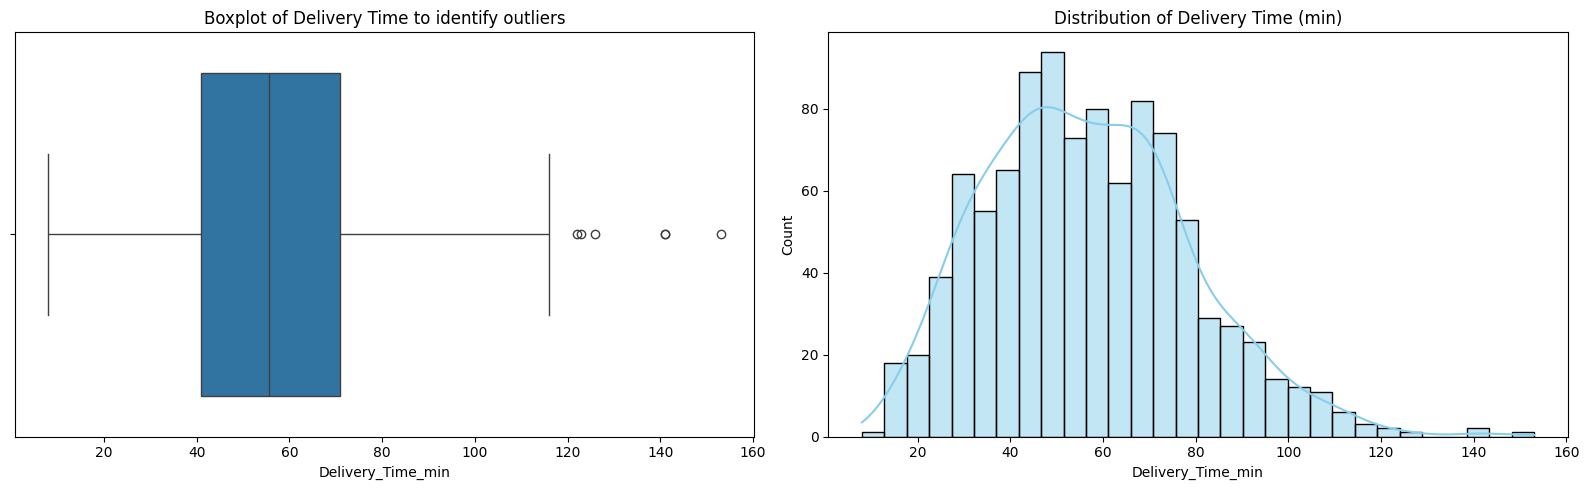

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_encoded['Delivery_Time_min'], data=df_encoded)
plt.title('Boxplot of Delivery Time to identify outliers')

plt.subplot(1, 2, 2)
sns.histplot(df_encoded['Delivery_Time_min'], kde=True, color='skyblue', bins=30)
plt.title("Distribution of Delivery Time (min)")

plt.tight_layout()
plt.show()


#### We are going to use the IQR Method to calculate our outlier values

In [11]:
q1 = df_encoded['Delivery_Time_min'].quantile(0.25)
q3 = df_encoded['Delivery_Time_min'].quantile(0.75)

upper_limit = q3 + 1.5 *(q3-q1)
lower_limit = q1 - 1.5 *(q3-q1)

print(f"Upper limit: {upper_limit}, Lower limit: {lower_limit}")

Upper limit: 116.0, Lower limit: -4.0


In [12]:
df_encoded[df_encoded['Delivery_Time_min'] > upper_limit]
df_encoded[df_encoded['Delivery_Time_min'] < lower_limit]
definitive_df = df_encoded[df_encoded['Delivery_Time_min'] < upper_limit]
definitive_df.shape



(992, 18)

#### We compare our datasets to see how trimming the outliers affect the data

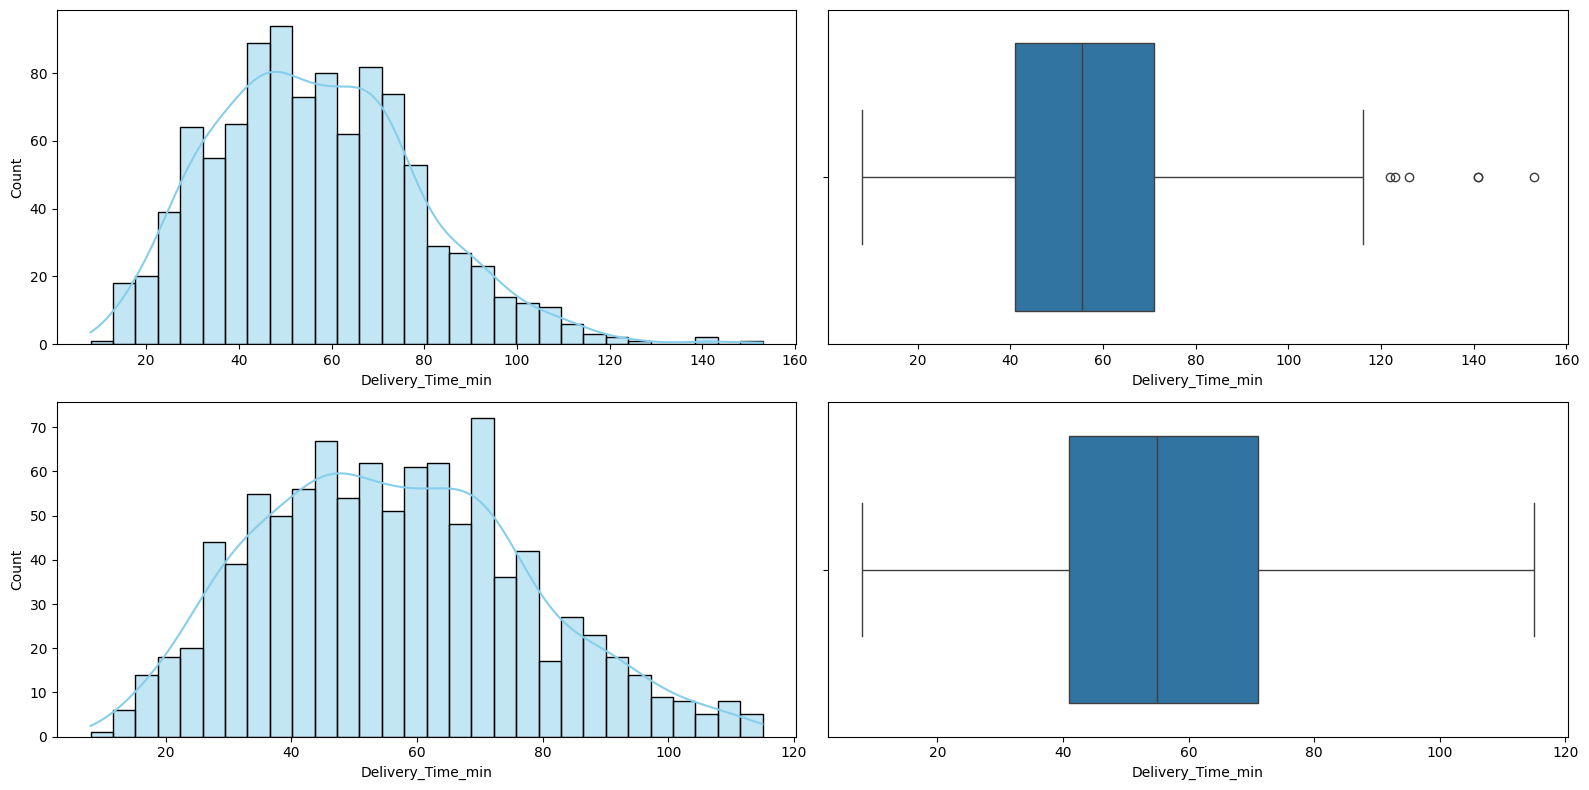

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
sns.histplot(df_encoded['Delivery_Time_min'], kde=True, color='skyblue', bins=30)
plt.subplot(2,2,2)
sns.boxplot(x=df_encoded['Delivery_Time_min'], data=df_encoded)
plt.subplot(2, 2, 3)
sns.histplot(definitive_df['Delivery_Time_min'], kde=True, color='skyblue', bins=30)
plt.subplot(2, 2, 4)
sns.boxplot(x=definitive_df['Delivery_Time_min'], data=definitive_df)
plt.tight_layout()
plt.show()


#### We applied winsorization to replace the outlier values in our target variable with their respective upper or lower boundaries. This technique helps to reduce the influence of extreme values without removing any data points from the dataset.


In [14]:
definitive_df_cap = df_encoded.copy()
definitive_df_cap['Delivery_Time_min'] = np.where(
    definitive_df_cap['Delivery_Time_min'] > upper_limit, 
    upper_limit, 
    np.where(
        definitive_df_cap['Delivery_Time_min'] < lower_limit, 
        lower_limit,
        definitive_df_cap['Delivery_Time_min']
    )
)

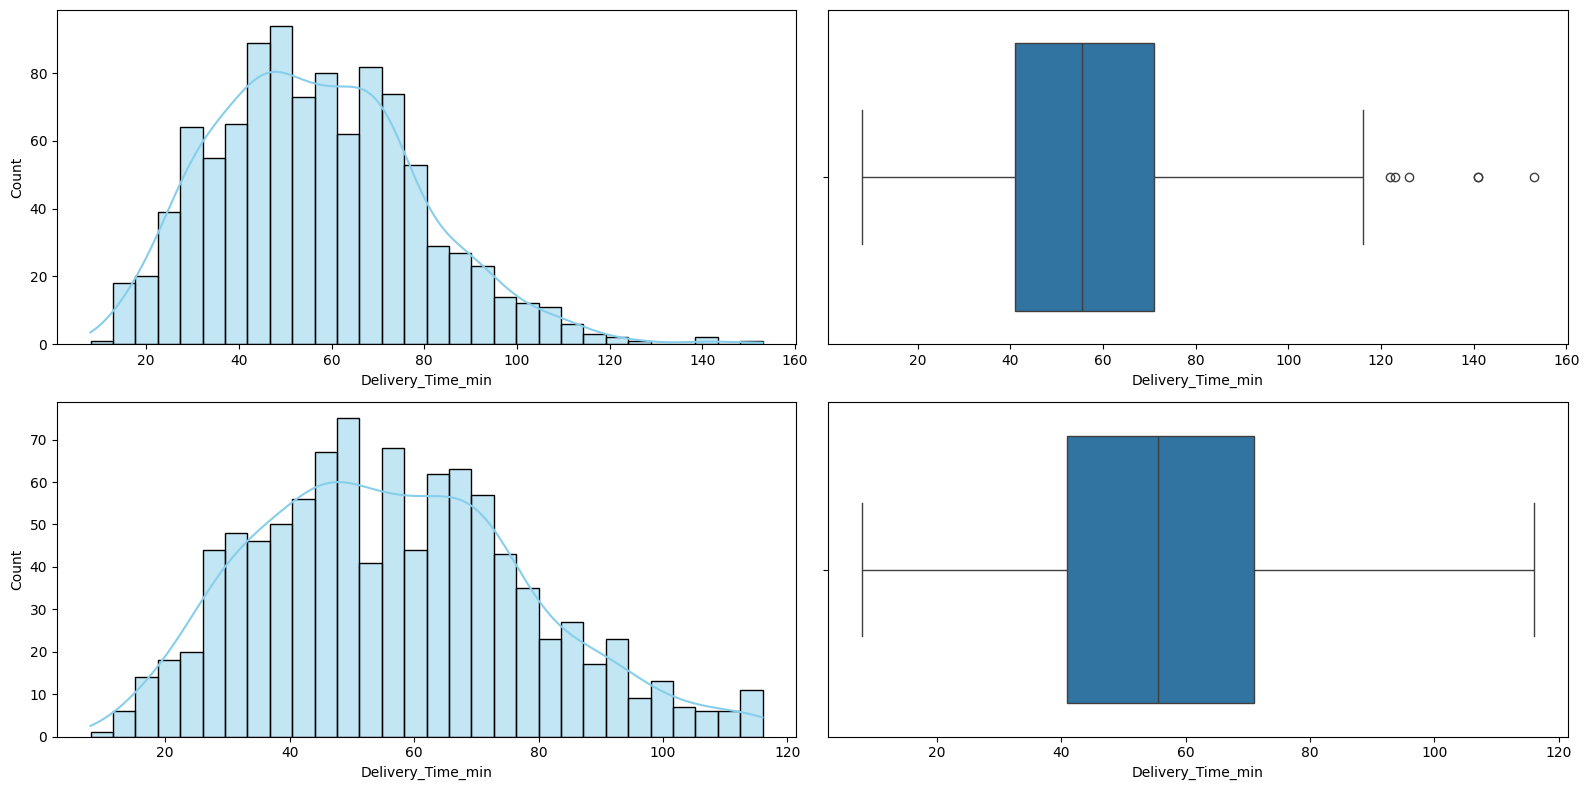

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df_encoded['Delivery_Time_min'], bins = 30, kde=True, color='skyblue')
plt.subplot(2,2,2)
sns.boxplot(x=df_encoded['Delivery_Time_min']   )
plt.subplot(2,2,3)
sns.histplot(definitive_df_cap['Delivery_Time_min'], bins =30, kde=True, color='skyblue')
plt.subplot(2,2,4)
sns.boxplot(x=definitive_df_cap['Delivery_Time_min'])
plt.tight_layout()
plt.show()

In [16]:
definitive_df_cap.to_csv("../Dataset/Food_Delivery_Times_Cleaned.csv", index=False)